# Урок 3. Построение надежных схем валидации решения, оптимизация целевых метрик

**Основное задание:**
Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов \- **ROC-AUC**, название целевой переменной \- **IsFraud**. Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые. **Внимание!** выборка `assignment_2_test.csv` \- наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. **Для других целей использовать выборку запрещено!**.
​
**Терминалогия, используемая в задании:**
\* обучающая выборка \- выборка, которая передается в метод `fit` / `train`;
\* валидационная выборка \- выборка, которая получается при Hold-Out на 2 выборки (`train`, `valid`);
\* тестовая выборка \- выборка, которая получается при Hold-Out на 3 выборки (`train`, `valid`, `test`);
\* ЛБ \- лидерборд, выборка `assignment_2_test.csv`.
​
**Задание 1:** сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (`TransactionID`), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.
​
**Задание 2:** сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.
​
**Задание 3:** построить доверительный интервал на данных из п.2 на основе **бутстреп** выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.
​
**Задание 4:** выполнить `Adversarial Validation`, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из `assignment_2_test.csv`, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.
​
**Задание 5:** сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.
​
**Задание 6** (опциональное): сделать Hold-Out валидацию по времени (`TransactionDT`), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.
​
**Задание 7** (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (`TransactionID`) и время транзакции (`TransactionDT`), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (`GroupKFold`).

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import seaborn as sns
import scipy.stats as st

import warnings
warnings.simplefilter("ignore")

import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
# Не успеваю с выполнением этого задания. 
# Пока  это только заглушка. В течение пары дней постараюсь выложить решение.

## Задание 1.

Cделать Hold-Out валидацию с разбиением, размер которого будет
 адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID),
 обучать модель градиетного бустинга любой реализации с подбором числа деревьев
 по early_stopping критерию до достижения сходимости. Оценить качество модели на 
 валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке
 и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации.
 Сделать выводы.

In [3]:
public_df = pd.read_csv('../assignment2_data/assignment_2_train.csv')
private_df = pd.read_csv('../assignment2_data/assignment_2_test.csv')

In [4]:
print("public_df.shape = {} rows, {} cols".format(*public_df.shape))
print("private_df.shape = {} rows, {} cols".format(*private_df.shape))

open_df.shape = 180000 rows, 394 cols
private_df.shape = 100001 rows, 394 cols


In [5]:
public_df.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
len(public_df['TransactionID'].value_counts())

180000

In [7]:
public_df[['TransactionID','isFraud','TransactionDT','TransactionAmt','addr1','addr2']]

,TransactionID,isFraud,TransactionDT,TransactionAmt,addr1,addr2
0,2987000,0,86400,68.50,315.0,87.0
1,2987001,0,86401,29.00,325.0,87.0
2,2987002,0,86469,59.00,330.0,87.0
3,2987003,0,86499,50.00,476.0,87.0
4,2987004,0,86506,50.00,420.0,87.0
...,...,...,...,...,...,...
179995,3166995,0,3958217,39.00,272.0,87.0
179996,3166996,0,3958237,59.95,315.0,87.0
179997,3166997,0,3958241,34.00,330.0,87.0
179998,3166998,0,3958260,59.00,272.0,87.0


In [8]:
public_df['addr1'].value_counts()

299.0    15678
325.0    12846
204.0    12729
264.0    11592
330.0     7419
         ...  
185.0        1
233.0        1
133.0        1
183.0        1
522.0        1
Name: addr1, Length: 269, dtype: int64

In [9]:
public_df['addr2'].value_counts()

87.0     157732
60.0       2107
96.0        347
32.0         61
16.0         43
31.0         42
65.0         28
26.0         20
19.0         19
69.0         16
102.0        11
59.0         10
29.0          9
98.0          8
17.0          7
57.0          7
71.0          7
13.0          7
72.0          6
88.0          5
68.0          5
52.0          5
21.0          5
48.0          4
24.0          3
101.0         3
47.0          3
78.0          3
39.0          3
44.0          3
34.0          3
10.0          3
23.0          2
86.0          2
30.0          2
76.0          2
54.0          2
43.0          2
97.0          2
63.0          2
66.0          2
62.0          2
73.0          1
50.0          1
83.0          1
70.0          1
75.0          1
15.0          1
49.0          1
14.0          1
35.0          1
25.0          1
22.0          1
27.0          1
Name: addr2, dtype: int64

In [10]:
# Разделим выборки на тренировчную, тестовую и валидационную.

In [11]:
x_train, x_test = train_test_split(public_df.drop(["TransactionID", "isFraud"], axis=1), train_size=0.60, shuffle=False, random_state=1,)
y_train, y_test = train_test_split(public_df["isFraud"], train_size=0.60, shuffle=False, random_state=1,) # В данных имеется временная зависимость, поэтому пока перемешивать ничего не будем.

In [12]:
# numerical_features = x_train.select_dtypes(exclude=["object"])
# numerical_features = numerical_features.columns.tolist()

# x_train = x_train[numerical_features]
# x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 392 cols
x_test.shape = 72000 rows, 392 cols


In [13]:
# Получим список катероиальных и числовых признаков.

categorical = []
numerical = []
for col, value in x_train.iteritems():
    if value.dtype == 'object':
        categorical.append(col)
    else:
        numerical.append(col)

In [14]:
x_train[categorical].head(5)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Выделим числовые и категриальные переменные. 

In [16]:
x_train[categorical]=x_train[categorical].astype('category')
x_test[categorical]=x_test[categorical].astype('category')

In [17]:
# lgb_dtrain_3 = lgb.Dataset(
#     data=x_train, label=y_train,categorical_feature=categorical
# )
# lgb_dvalid_3 = lgb.Dataset(
#     data=x_test, label=y_test,categorical_feature=categorical
# )

In [18]:
params = {
    "booster": "gbtree",
    # "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 50,
    "max_depth": 4,
    "gamma": 4,
    "nthread": 6,
    # "seed": 27,
    'random_state':1
    
}

In [19]:
model = lgb.LGBMClassifier(**params)

model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    early_stopping_rounds=25,
    categorical_feature=categorical,
    # num_boost_round=10000,
    eval_metric="auc",
    verbose=20
)

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=6 will be ignored. Current value: num_threads=-1
[20]	training's auc: 0.891467	training's binary_logloss: 0.0782767	valid_1's auc: 0.865487	valid_1's binary_logloss: 0.105435
[40]	training's auc: 0.905077	training's binary_logloss: 0.0709057	valid_1's auc: 0.872462	valid_1's binary_logloss: 0.0996511
[60]	training's auc: 0.91297	training's binary_logloss: 0.0671989	valid_1's auc: 0.876831	valid_1's binary_logloss: 0.0970317
[80]	training's auc: 0.918017	training's binary_logloss: 0.0649879	valid_1's auc: 0.878539	valid_1's binary_logloss: 0.0961891
[100]	training's auc: 0.922365	training's binary_logloss: 0.0629449	valid_1's auc: 0.879982	valid_1's binary_logloss: 0.095173
[120]	training's auc: 0.92593	training's binary_logloss: 0.0614697	valid_1's auc: 0.881412	valid_1's binary_

LGBMClassifier(booster='gbtree', eval_metric='auc', gamma=4, max_depth=4,
               n_estimators=10000, nthread=6, random_state=1, reg_lambda=50)

In [20]:
# model = xgb.XGBRegressor(random_state=1)
# model.fit(x_train, y_train)

In [21]:
# недообучение - 5
# переобучение +
# все ок = 2

In [22]:
def draw_roc_auc(model, dtrain, dvalid, y_train, y_valid):
    #  тест   
    try:
        y_pred_train = model.predict_proba(dtrain)[:,1]      
    except:
        y_pred_train = model.predict(dtrain)
    roc_auc_train=roc_auc_score(y_train, y_pred_train)
    # print(roc_auc_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_pred_train)

    try:
        y_pred_val = model.predict_proba(dvalid)[:,1]      
    except:
        y_pred_val = model.predict(dvalid)
    roc_auc_val=roc_auc_score(y_valid, y_pred_val)
    # print(roc_auc_val)
    fpr_val, tpr_val, _ = metrics.roc_curve(y_valid, y_pred_val)

    plt.plot(fpr_train, tpr_train, 'b',color="blue", label = 'train_auc = %0.2f' % roc_auc_train)
    plt.plot(fpr_val, tpr_val, 'b', color="orange", label = 'val_auc = %0.2f' % roc_auc_val)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

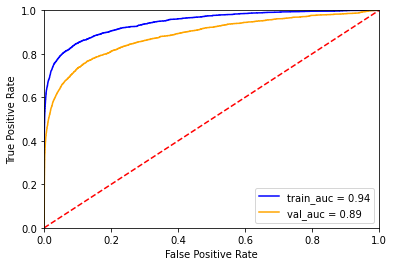

In [23]:
draw_roc_auc(model, x_train, x_test, y_train, y_test )

In [31]:
y_pred_train = model.predict_proba(x_train)[:,1]

In [32]:
roc_auc_score(y_train, y_pred_train)

0.9448938148202939

In [33]:
y_pred_train = model.predict(x_train)

In [34]:
roc_auc_score(y_train, y_pred_train)

0.7217544878734727

In [24]:
train_score =  roc_auc_score(y_train, model.predict(x_train))
test_score = roc_auc_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.722, Test-score: 0.641


In [35]:
lgb_dtrain_3 = lgb.Dataset(
    data=x_train, label=y_train,categorical_feature=categorical
)
lgb_dvalid_3 = lgb.Dataset(
    data=x_test, label=y_test,categorical_feature=categorical
)

In [36]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 100,
    "reg_lambda": 50,
    "max_depth": 4,
    "gamma": 4,
    "nthread": 6,
    "seed": 27,
    # 'random_state':1    
}

In [37]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 100,
    # "reg_lambda": 50,
    # "max_depth": 4,
    "n_jobs": 6,
    "seed": 27
}

In [38]:
lgb_model_3 = lgb.train(
    params=params,
    train_set=lgb_dtrain_3,
    num_boost_round=10000,
    valid_sets=[lgb_dtrain_3, lgb_dvalid_3],
    # feature_name=categorical,
    categorical_feature=categorical,
    early_stopping_rounds=50,
    verbose_eval=25
)

[LightGBM] [Info] Number of positive: 2689, number of negative: 105311
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31191
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 390
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024898 -> initscore=-3.667748
[LightGBM] [Info] Start training from score -3.667748
Training until validation scores don't improve for 50 rounds
[25]	training's auc: 0.934711	valid_1's auc: 0.877165
[50]	training's auc: 0.961895	valid_1's auc: 0.886831
[75]	training's auc: 0.975034	valid_1's auc: 0.883186
[100]	training's auc: 0.98397	valid_1's auc: 0.882191
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.98397	valid_1's auc: 0.882191


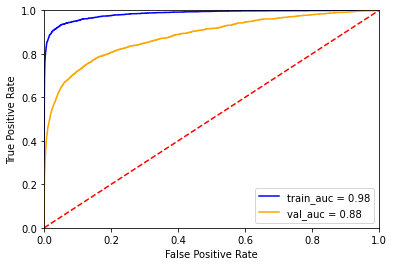

In [39]:
draw_roc_auc(lgb_model_3, x_train, x_test, y_train, y_test )

In [40]:
train_score =  roc_auc_score(y_train, model.predict(x_train))
test_score = roc_auc_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.722, Test-score: 0.641


## Задание 2.

Cделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [41]:
x_test, x_val = train_test_split(x_test, train_size=0.50, shuffle=False, random_state=1,)
y_test, y_val = train_test_split(y_test, train_size=0.50, shuffle=False, random_state=1,)

In [46]:
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_val.shape = {} rows, {} cols".format(*x_val.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 392 cols
x_val.shape = 36000 rows, 392 cols
x_test.shape = 36000 rows, 392 cols


In [43]:
model = lgb.LGBMClassifier(**params)

model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_val, y_val), (x_val, y_val)],
    early_stopping_rounds=50,
    categorical_feature=categorical,
    # num_boost_round=10000,
    eval_metric="auc",
    verbose=20
)

[20]	valid_0's auc: 0.861798	valid_1's auc: 0.861798
[40]	valid_0's auc: 0.870674	valid_1's auc: 0.870674
[60]	valid_0's auc: 0.873974	valid_1's auc: 0.873974
[80]	valid_0's auc: 0.868605	valid_1's auc: 0.868605


LGBMClassifier(metric='auc', n_jobs=6, objective='binary', seed=27)

In [44]:
train_score =  roc_auc_score(y_train, model.predict(x_train))
val_score = roc_auc_score(y_val, model.predict(x_val))
test_score = roc_auc_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.756, Val-score: 0.635, Test-score: 0.641


In [48]:
train_score =  roc_auc_score(y_train, model.predict_proba(x_train)[:,1])
val_score = roc_auc_score(y_val, model.predict_proba(x_val)[:,1])
test_score = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])

print(f"Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.966, Val-score: 0.875, Test-score: 0.902


## Задание 3.

Построить доверительный интервал на данных из п.2 на основе **бутстреп** выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [50]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [51]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model.predict(x_test), roc_auc_score)

calculate_confidence_interval(scores)

(0.6286071778953064, 0.6550466168452221)

Text(0.5, 0, 'sampel number')

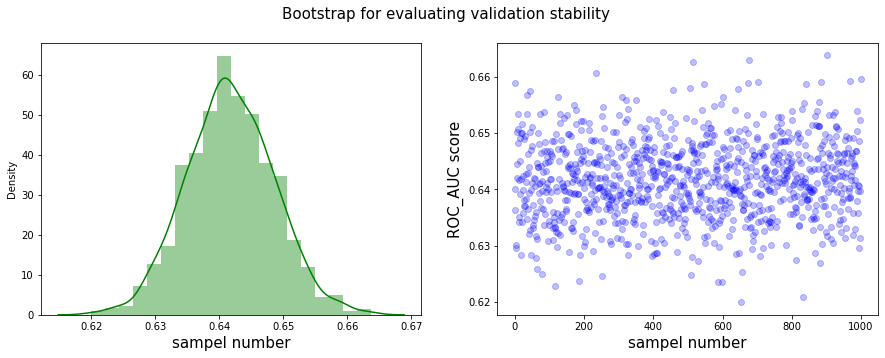

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("ROC_AUC score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

Модель показывает достаточно очень небольшой разброс на разных bootstrep выборках.
Наверное это хороший знак. зачения в распеделениы достаточно равномерно.

In [53]:
x_private = private_df.drop(["TransactionID", "isFraud"], axis=1)
y_private = private_df["isFraud"]

In [55]:
x_private[categorical]=x_private[categorical].astype('category')

In [56]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_private, model.predict(x_private), roc_auc_score)

calculate_confidence_interval(scores)

(0.5943973262832392, 0.6067763629144574)

Text(0.5, 0, 'sampel number')

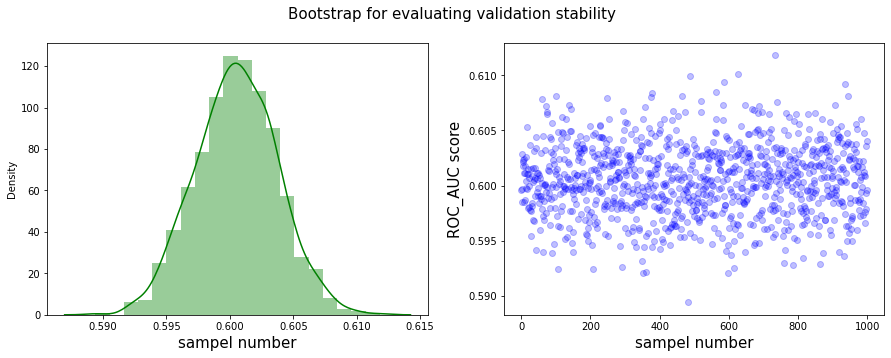

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("ROC_AUC score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

In [ ]:
Видно, что распреление на зкшмуеу ЛБ немного смещено вниз. 
т.е. он показывает несколько меньший результат.

## Задание 4. 

Выполнить `Adversarial Validation`, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из `assignment_2_test.csv`, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

## Задание 5.

Сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.


## Задание 6 (опциональное).

Сделать Hold-Out валидацию по времени (`TransactionDT`), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.


## Задание 7 (совсем опциональное).

В данном наборе данных у нас есть ID-транзакции (`TransactionID`) и время транзакции (`TransactionDT`), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (`GroupKFold`).